In [10]:
# Austin Kang
# 3031916395
# README: The random seed I used was 1. The script can be run sequentially, producing titanic.csv and spam.csv.
# Please make sure all dependencies are installed. I had to hack, i.e. place graphviz-master/graphviz from the 
# graphviz github into the working directory and then modify rcviz.py's dependency structure to make the last 
# graph for 3.6 work. Data can be added by placing the data into a "datasets" folder in the CWD (so the "spam_data",
# "titanic" folders are in "datasets").

import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
import math
import save_csv
import random
from sklearn.model_selection import KFold, ShuffleSplit


import pydot
import matplotlib.pyplot as plt

eps = 1e-5  # a small number

<P style="page-break-before: always"> 

In [11]:
class DecisionTree:
    def __init__(self, max_depth=10, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.max_split_idx, self.max_split = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m

    @staticmethod
    def H(y):
        terms = []
        counter = Counter()
        for label in y:
            counter[label] += 1
        for value in counter.most_common():
            terms.append(-value[-1]/len(y) * math.log(value[-1]/len(y), 2))
        return sum(terms)
    
    @staticmethod
    def H_after(X, y):
        # TODO implement gini_impurity function
        
        zipped = zip(X, y)
        in_order = sorted(zipped, key=lambda x: x[0])
        sorted_X, sorted_y = zip(*in_order)
        max_x, min_x = sorted_X[-1], sorted_X[0]
        total = sum(y)
        
        C = 0
        c = total
        D = 0
        d = len(y) - total
        previous = sorted_X[0]
        
        weighted_entropies = []
        splits = []
        changed = False
        for i in np.arange(len(sorted_X)):
            # maybe change this so that we're not splitting on exact min/max values
            if sorted_X[i] > previous:
                changed = True
                previous = sorted_X[i]
                left1 = -C * math.log(C/(C + D), 2) if C != 0 else 0
                left2 = -D * math.log(D/(C + D), 2) if D != 0 else 0
                right1 = -c * math.log(c/(c + d), 2) if c != 0 else 0
                right2 = -d * math.log(d/(c + d), 2) if d != 0 else 0
                if (sorted_X[i] == max_x):
                    splits.append(previous - eps)
                elif (sorted_X[i] == min_x):
                    splits.append(previous + eps)
                else:
                    splits.append(previous)
                weighted_entropies.append((1/(len(y)) * (left1 + left2 + right1 + right2)))
            value = sorted_y[i]
            C += value
            c -= value
            D += (value - 1) * -1
            d -= (value - 1) * -1
                
        if not changed:
            return 1, .5
        
        return min(weighted_entropies), splits[np.argmin(weighted_entropies)]
    
    @staticmethod
    def max_information_gain_for_x(X, y):
        # TODO implement information gain function
        gain, split = DecisionTree.H_after(X, y)
        return DecisionTree.H(y) - gain, split

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            splits = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits
            if self.m != None:
                features = np.random.choice(range(len(self.features)), m, replace=False)
            else:
                features = range(len(X[0]))
            for i in features:
                gain, split = self.max_information_gain_for_x(X[:, i], y)                        
                gains.append(gain)
                splits.append(split)

            gains = np.nan_to_num(np.array(gains))                                                             
            self.max_split_idx = np.argmax(gains)
            self.max_split = splits[self.max_split_idx]   
                                              
            X0, y0, X1, y1 = self.split(X, y, idx=self.max_split_idx, thresh=self.max_split)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features, m=self.m)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.features = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.features = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.max_split_idx, thresh=self.max_split)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    #fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode
            for j in range(len(data[:, i])):
                if data[j][i] == -1:
                    data[j][i] = mode
            #print (data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i])

    #if k_nearest_neighbors_mode:
        
        
    return data, onehot_features


"""
def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)
"""
    
        

'\ndef evaluate(clf):\n    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))\n    if hasattr(clf, "decision_trees"):\n        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])\n        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]\n        print("First splits", first_splits)\n'

In [12]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200, m=None):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.m = m
        self.decision_trees = [
            DecisionTree(10, self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO implement function
        for tree in self.decision_trees:
            bag = np.random.choice(range(len(X)), self.n)
            tree.fit(X[bag], y[bag])

    def predict(self, X):
        # TODO implement function
        predictions = []
        total = np.zeros(len(X))
        for tree in self.decision_trees:
            predictions.append(tree.predict(X))
        for prediction in predictions:
            total = np.add(total, prediction)
        for i in np.arange(len(total)):
            if total[i] / len(predictions) < .5:
                total[i] = 0
            else:
                total[i] = 1
        return total

In [13]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=4):
        BaggedTrees.__init__(self, params, n, m)
        pass


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO implement function
        return self

    def predict(self, X):
        # TODO implement function
        pass

In [14]:
    random.seed(1) 

In [15]:
def main(dataset):
    
    if dataset == "titanic":
        params = {
            "max_depth": 5,
            # "random_state": 6,
            "min_samples_leaf": 10,
        }
        N = 100
        # Load titanic data
        path_train = 'datasets/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None)
        path_test = 'datasets/titanic/titanic_testing_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None)
        y = data[1:, 0]  # label = survived
        class_names = ["Died", "Survived"]

        labeled_idx = np.where(y != b'')[0]
        y = np.array(y[labeled_idx], dtype=np.int)
        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, 1:]) + onehot_features
        
    elif dataset == "spam":
        features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
        "height", "featured", "differ", "width", "other", "energy", "business", "message",
        "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
        "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'datasets/spam_data/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

        

    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z))

    print("DecisionTree kfold")
    ss = ShuffleSplit(n_splits=5)

    totals = []
    for train_index, test_index in ss.split(X):
        dt = DecisionTree(max_depth=3, feature_labels=features)
        dt.fit(X[train_index], y[train_index])
        predictions = dt.predict(X[test_index])
        total = 0
        for i in range(len(predictions)):
            total += predictions[i] == y[test_index][i]
        totals.append(total/len(predictions))
    print(np.mean(totals))


    #bagged
    bt = BaggedTrees(features, 200)
    bt.fit(X, y)
    print("BaggedTrees kfold")
    totals1 = []
    for train_index, test_index in ss.split(X):
        bt = BaggedTrees(features, 200)
        bt.fit(X[train_index], y[train_index])
        predictions = bt.predict(X[test_index])
        total = 0
        for i in range(len(predictions)):
            total += predictions[i] == y[test_index][i]
        totals1.append(total/len(predictions))
    print(np.mean(totals1))
    
    #random forest
    rf = RandomForest(features, 200, m = 4)
    rf.fit(X, y)
    save_csv.results_to_csv(rf.predict(Z), dataset)

    print("RandomForests kfold")
    totals2 = []
    for train_index, test_index in ss.split(X):
        rf = RandomForest(features, 200, m=4)
        rf.fit(X[train_index], y[train_index])
        predictions = rf.predict(X[test_index])
        total = 0
        for i in range(len(predictions)):
            total += predictions[i] == y[test_index][i]
        totals2.append(total/len(predictions))
    print(np.mean(totals2))
    

In [16]:
main("titanic")



Part (b): preprocessing the titanic dataset
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.613613613614


Part (a-b): simplified decision tree
Predictions [ 1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.
  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  0.
  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  1.  0. 

In [17]:
main("spam")

Train/test size: (5172, 32) (5857, 32)


Part 0: constant classifier
Accuracy 0.709976798144


Part (a-b): simplified decision tree
Predictions [ 0.  1.  0. ...,  0.  0.  1.]
DecisionTree kfold
0.793436293436
BaggedTrees kfold
0.81583011583
RandomForests kfold
0.811583011583


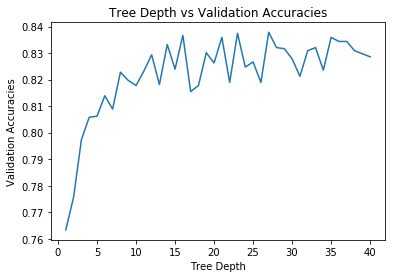

In [34]:
    # 3.5.3
    
features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
    "height", "featured", "differ", "width", "other", "energy", "business", "message",
    "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
    "ampersand"
    ]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]


validation_accuracies = []

ss = ShuffleSplit(n_splits=5)
    for i in range(1, 41):
        totals = []
        for train_index, test_index in ss.split(X):
            dt = DecisionTree(max_depth=i, feature_labels=features)
            dt.fit(X[train_index], y[train_index])
            predictions = dt.predict(X[test_index])
            total = 0
            for j in range(len(predictions)):
                total += predictions[j] == y[test_index][j]
            totals.append(total/len(predictions))
        validation_accuracies.append(np.mean(totals))
    plt.plot(range(1, 41), validation_accuracies)
    plt.title("Tree Depth vs Validation Accuracies")
    plt.xlabel("Tree Depth")
    plt.ylabel("Validation Accuracies")
    plt.show()

This behavior is expected; With lower tree depth comes lower accuracy scores (for the decision tree) because of higher bias. 

<P style="page-break-before: always"> 

In [35]:
    # 3.6
params = {
        "max_depth": 5,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100
    # Load titanic data
    path_train = 'datasets/titanic/titanic_training.csv'
    data = genfromtxt(path_train, delimiter=',', dtype=None)
    path_test = 'datasets/titanic/titanic_testing_data.csv'
    test_data = genfromtxt(path_test, delimiter=',', dtype=None)
    y = data[1:, 0]  # label = survived
    class_names = ["Died", "Survived"]

    labeled_idx = np.where(y != b'')[0]
    y = np.array(y[labeled_idx], dtype=np.int)
    print("\n\nPart (b): preprocessing the titanic dataset")
    X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
    X = X[labeled_idx, :]
    Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
    assert X.shape[1] == Z.shape[1]
    features = list(data[0, 1:]) + onehot_features

    from rcviz import CallGraph, viz
    
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    predictions = dt.predict(Z)



Part (b): preprocessing the titanic dataset


(0.99999000000000005, b'male')
callviz: Rendering in inline in Jupyter Notebook


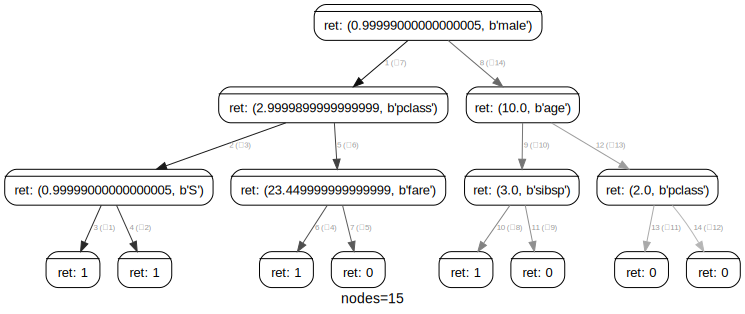

In [36]:
cg = CallGraph()

@viz(cg)
def walk(tree):
    if tree.left == None and tree.right == None:
        return tree.pred
    else:
        left = walk(tree.left)
        right = walk(tree.right)
        return tree.max_split, features[tree.max_split_idx]

    
print(walk(dt))
cg.render()

<P style="page-break-before: always"> 

<div class="text">
<pre>















<font size="6">
Code Appendix

3.1   -> page 2-5

3.2   -> page 6

3.4   -> page 7-10

3.5.3 -> page 11-12

3.6   -> page 13-14

</font>
</pre>
</div>